In [2]:
%load_ext autoreload
%autoreload 2

import sys
from functools import partial
import importlib

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import h5py

sys.path.append('../../../')
import forward_model
importlib.reload(forward_model)

from forward_model.fourier import my_fft, my_ifft, get_k, get_one_over_k_sq
from forward_model.calculus import divergence_hat, gradient_hat
from forward_model.ics import get_delta
from forward_model.lpt_displacements import get_psi_lpt1, get_psi_lpt2, get_psi_sc, get_psi_alpt
from forward_model.utils import compute_or_load_D1_D2, compute_or_load_pow_spec

from forward_model.plot_utils import plot_cubes, compare_deltas, compare_pow_spec, scatter_density

Let's see if everything is good

In [3]:
N, L, Z_I, Z_F = 128, 180, 99, 0

D1, D2 = compute_or_load_D1_D2(Z_I, Z_F)
pow_spec = compute_or_load_pow_spec(N, L, Z_I)

SEED_INT = 1
key = jax.random.PRNGKey(SEED_INT)
input_arr = jax.random.normal(key, shape=(N**3,))

k_sq = get_k(N, L)**2
one_over_k_sq = get_one_over_k_sq(N, L)

delta_in = get_delta(
    input_arr,
    N,
    L,
    INPUT_ARG="U",
    pow_spec=pow_spec,
    return_hat=False,
)
delta_in_hat = my_fft(delta_in, L)


x = -D1 * delta_in


phi_1_hat = -delta_in_hat * one_over_k_sq 

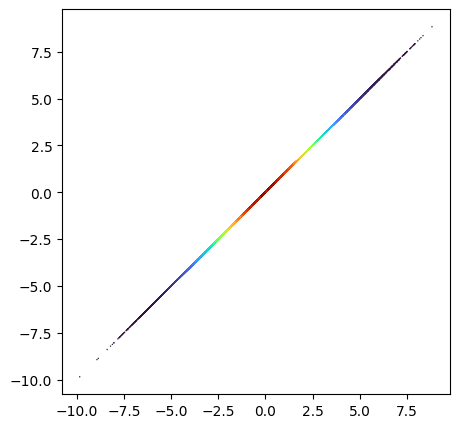

In [4]:
# LPT1
psi_x_hat, psi_y_hat, psi_z_hat = get_psi_lpt1(phi_1_hat, N, L)
div_psi_hat = divergence_hat(psi_x_hat, psi_y_hat, psi_z_hat, N, L)
div_psi_lpt1 = my_ifft(div_psi_hat, L) * D1

fs, rat = 5, 1
fig, ax = plt.subplots(1,1,figsize=(fs*rat, fs))
step = 10
scatter_density(ax, x, div_psi_lpt1, step=step)

conclusion

SC well ipmlemented. the stretch factor is equal to the 'theory one', or the prescription for SC. Regarding muscle, shape is werid, but i guess it should be tlike  hits. And there basicaly no difference between  one iteration and many it seems. 

-669790.06
-0.001953125


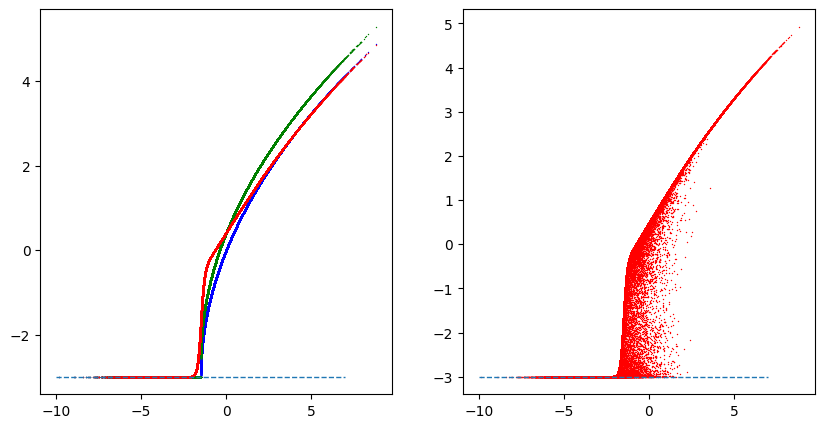

In [6]:
delta_in_ = delta_in.astype(complex)
div_psi_sc_th = 3 * jnp.sqrt(1 - 2 / 3 * D1 * delta_in_).real - 3.0

bool_arr = D1 * delta_in < 3 / 2
sum_div_psi = jnp.sum(div_psi_sc_th)
print(sum_div_psi)
num = jnp.sum(bool_arr)
fact = sum_div_psi / num
div_psi_sc_th_corr = jnp.where(bool_arr, div_psi_sc_th - fact, div_psi_sc_th)
print(jnp.sum(div_psi_sc_th_corr))

MUSCLE = False
MUSCLE_ITERS = "ONE"
SC_CORRECTION = True
psi_x_hat, psi_y_hat, psi_z_hat = get_psi_sc(
    delta_in,
    D1,
    k_sq,
    N,
    L,
    MUSCLE=MUSCLE,
    MUSCLE_ITERS=MUSCLE_ITERS,
    SC_CORRECTION=SC_CORRECTION,
)
div_psi = divergence_hat(psi_x_hat, psi_y_hat, psi_z_hat, N, L)
div_psi_sc = my_ifft(div_psi, L)

fs, rat = 5, 2
fig, axs = plt.subplots(1, 2, figsize=(fs * rat, fs))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

axs[0].scatter(x.ravel()[::step], div_psi_sc_th.ravel()[::step], c="b", s=1, lw=0)
axs[0].scatter(x.ravel()[::step], div_psi_sc_th_corr.ravel()[::step], c="g", s=1, lw=0)

axs[0].scatter(x.ravel()[::step], div_psi_sc.ravel()[::step], c="r", s=1, lw=0)




MUSCLE = True
MUSCLE_ITERS = "ONE"
SC_CORRECTION = True
psi_x_hat, psi_y_hat, psi_z_hat = get_psi_sc(
    delta_in,
    D1,
    k_sq,
    N,
    L,
    MUSCLE=MUSCLE,
    MUSCLE_ITERS=MUSCLE_ITERS,
    SC_CORRECTION=SC_CORRECTION,
)
div_psi = divergence_hat(psi_x_hat, psi_y_hat, psi_z_hat, N, L)
div_psi_sc = my_ifft(div_psi, L)
axs[1].scatter(x.ravel()[::step], div_psi_sc.ravel()[::step], c="r", s=1, lw=0)

# MUSCLE = True
# MUSCLE_ITERS = "ONE"
# SC_CORRECTION = True
# psi_x_hat, psi_y_hat, psi_z_hat = get_psi_sc(
#     delta_in,
#     D1,
#     k_sq,
#     N,
#     L,
#     MUSCLE=MUSCLE,
#     MUSCLE_ITERS=MUSCLE_ITERS,
#     SC_CORRECTION=SC_CORRECTION,
# )
# div_psi = divergence_hat(psi_x_hat, psi_y_hat, psi_z_hat, N, L)
# div_psi_sc = my_ifft(div_psi, L)
# axs[1].scatter(x.ravel()[::step], div_psi_sc.ravel()[::step], c="b", s=1, lw=0)


# axs[0].plot([-10, 7],[-0.5, -0.5], lw=1, ls='--')
axs[0].plot([-10, 7],[-3, -3], lw=1, ls='--')
axs[1].plot([-10, 7],[-3, -3], lw=1, ls='--')

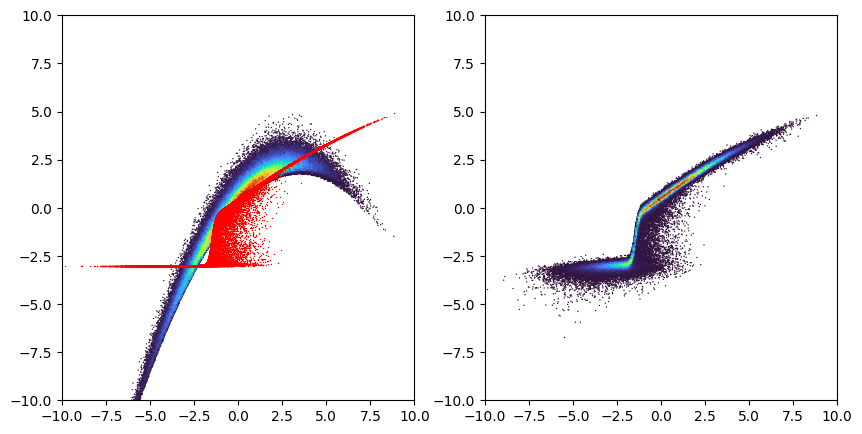

In [7]:
fs, rat = 5, 2
fig, axs = plt.subplots(1, 2, figsize=(fs * rat, fs))
plt.subplots_adjust(wspace=0.2, hspace=0.2)


# LPT2
psi_x_hat, psi_y_hat, psi_z_hat = get_psi_lpt2(phi_1_hat, D1, D2, one_over_k_sq, N, L)
div_psi_hat = divergence_hat(psi_x_hat, psi_y_hat, psi_z_hat, N, L)
div_psi_lpt2 = my_ifft(div_psi_hat, L)

step = 10
scatter_density(axs[0], x, div_psi_lpt2, step=step)
axs[0].scatter(x.ravel()[::step], div_psi_sc.ravel()[::step], c="r", s=1, lw=0)


MUSCLE = True
MUSCLE_ITERS = "ONE"
SC_CORRECTION = True
R_S = 2
psi_x_hat, psi_y_hat, psi_z_hat = get_psi_alpt(
    delta_in_hat,
    D1,
    D2,
    k_sq,
    N,
    L,
    R_S=R_S,
    MUSCLE=MUSCLE,
    MUSCLE_ITERS=MUSCLE_ITERS,
    SC_CORRECTION=SC_CORRECTION,
)
div_psi = divergence_hat(psi_x_hat, psi_y_hat, psi_z_hat, N, L)
div_psi = my_ifft(div_psi, L)

step = 10
scatter_density(axs[1], x, div_psi, step=step)

for ax in axs:
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)